<a href="https://colab.research.google.com/github/radhika1112/data-science-dissertation/blob/master/Analysing_twitter_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this notebook, we will analyse the twitter data**

**From the 3 million large dataset, we will extract conversations of three companies and analyse the response times, group them and order them.**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load entire 3 million twitter dataset

In [0]:
import pandas as pd 
root_path = 'gdrive/My Drive/twcs.csv/'
df=pd.read_csv('gdrive/My Drive/twcs.csv')

In [0]:
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [0]:
df.shape

(2811774, 7)

# Apple Support Dataset - subset1

In [0]:
subset1 = df[(df['author_id'].str.contains('AppleSupport'))|df['text'].str.contains('AppleSupport')]
subset1.shape

(204028, 7)

In [0]:
subset1.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
396,696,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698.0
397,697,115854,True,Tue Oct 31 22:31:23 +0000 2017,@AppleSupport The newest update. I️ made sure ...,699,696.0
398,699,AppleSupport,False,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...,NaN,697.0
399,698,115854,True,Tue Oct 31 22:17:40 +0000 2017,@AppleSupport https://t.co/NV0yucs0lB,696,700.0
400,700,115854,True,Tue Oct 31 22:16:56 +0000 2017,@AppleSupport why are my I️’s changing not sho...,698,NaN


## Analyse Response time

In [0]:


#Separating the original dataframe into inbounds and outbounds
inbounds = subset1.loc[subset1['inbound'] == True]
outbounds = subset1.loc[subset1['inbound'] == False]

#Merging/joining to be able to later find time between responses. Messy as a variable because the table looks so messy.
messy = pd.merge(outbounds, inbounds, left_on='in_response_to_tweet_id', right_on='tweet_id', how='outer')

#Changing timestamp format
messy['outbound_time'] = pd.to_datetime(messy['created_at_x'], format='%a %b %d %H:%M:%S +0000 %Y')
messy['inbound_time'] = pd.to_datetime(messy['created_at_y'], format='%a %b %d %H:%M:%S +0000 %Y')

#Calculating time between between outbound response and inbound message
messy['response_time'] = messy['outbound_time'] - messy['inbound_time']

messy.head()

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y,outbound_time,inbound_time,response_time
0,696.0,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698.0,698.0,115854,True,Tue Oct 31 22:17:40 +0000 2017,@AppleSupport https://t.co/NV0yucs0lB,696,700.0,2017-10-31 22:27:49,2017-10-31 22:17:40,00:10:09
1,699.0,AppleSupport,False,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...,NaN,697.0,697.0,115854,True,Tue Oct 31 22:31:23 +0000 2017,@AppleSupport The newest update. I️ made sure ...,699,696.0,2017-10-31 22:36:27,2017-10-31 22:31:23,00:05:04
2,701.0,AppleSupport,False,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...,NaN,702.0,702.0,115855,True,Tue Oct 31 22:11:31 +0000 2017,@AppleSupport Tried resetting my settings .. r...,701,703.0,2017-10-31 22:26:49,2017-10-31 22:11:31,00:15:18
3,703.0,AppleSupport,False,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...,702,704.0,704.0,115855,True,Tue Oct 31 21:59:17 +0000 2017,@AppleSupport This is what it looks like https...,703,705.0,2017-10-31 22:09:52,2017-10-31 21:59:17,00:10:35
4,705.0,AppleSupport,False,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...,"706,704",707.0,707.0,115855,True,Tue Oct 31 21:48:51 +0000 2017,@AppleSupport I️ have an iPhone 7 Plus and yes...,705,708.0,2017-10-31 21:57:00,2017-10-31 21:48:51,00:08:09


In [0]:
#Making sure the data type is a timedelta/duration
print('from ' + str(messy['response_time'].dtype))

#Making it easier to later do averages by converting to a float datatype
messy['converted_time'] = messy['response_time'].astype('timedelta64[s]') / 60

print('to ' + str(messy['converted_time'].dtype))

from timedelta64[ns]
to float64


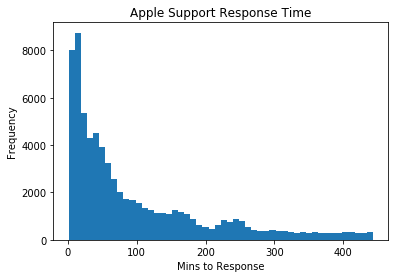

Apple support's average response time is 98.98 minutes.


In [0]:
#I saw it says 94 mins is the average time it takes for a response. This does not seem realistic.
#Focusing in on Uber and taking out outliers.

AS = messy[messy['author_id_x'] == 'AppleSupport']
AS_times = AS['converted_time']

AS_times.dropna()

def remove_outlier(AS_times):
    q1 = AS_times.quantile(0.25)
    q3 = AS_times.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = AS_times.loc[(AS_times > fence_low) & (AS_times < fence_high)]
    return df_out

no_outliers = remove_outlier(AS_times)

import matplotlib.pyplot as plt
hist_plot = no_outliers.plot.hist(bins=50)
hist_plot.set_title('Apple Support Response Time')
hist_plot.set_xlabel('Mins to Response')
hist_plot.set_ylabel('Frequency')
plt.show()

print('Apple support\'s average response time is ' + str(round(no_outliers.mean(),2)) + ' minutes.' )




In [0]:
subset=subset1[:10000]

## Order the conversations logically

In [0]:

#collecting all the unique author id's
All_author_ids = set(subset.author_id)
All_author_ids.remove('AppleSupport')


In [0]:
#collecting all the unique author id's
All_author_ids = set(subset.author_id)
All_author_ids.remove('AppleSupport')
import numpy as np
#array containing the correct order index to be used on data
correct_order = np.arange(len(subset))
#array containig the dialog id, count a unique number indicating each dialog 

#the main magic
for i, author_id in enumerate(All_author_ids):
    #boolean array: true where condition indidcated is met
    index = (subset.author_id == author_id) | subset.text.str.contains(str(author_id), na=True)
    #sampling the data, and ordering sample by time (created_at)
    order = subset.created_at[index].argsort()
    #rearranging the chuncks of the correct_order array based in order above
    correct_order[index] = correct_order[index][order]
    dialog_index[index] = i
    
subset = subset.reindex(correct_order)
subset.insert(5, 'dialog_index', dialog_index)
subset.to_csv('AppleSupport1-ordered.csv')


In [0]:
subset.shape

(10000, 8)

In [0]:
dia=subset.dialog_index.tolist()
len(dia)

10000

In [0]:
subset_conv=subset1[:10000]

add a column dialog_index to the main dataframe (subset of 2000) of apple support 

In [0]:
subset_conv['dialog_index']=dia
subset_conv.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,dialog_index
396,696,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698.0,1948
397,697,115854,True,Tue Oct 31 22:31:23 +0000 2017,@AppleSupport The newest update. I️ made sure ...,699,696.0,1948
398,699,AppleSupport,False,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...,NaN,697.0,1948
399,698,115854,True,Tue Oct 31 22:17:40 +0000 2017,@AppleSupport https://t.co/NV0yucs0lB,696,700.0,1948
400,700,115854,True,Tue Oct 31 22:16:56 +0000 2017,@AppleSupport why are my I️’s changing not sho...,698,NaN,1948


## grouping the conversations

In [0]:
# df = (lelle.groupby('dialog_index')['text']
#                             .apply(lambda x: np.mean(x.str.len()))
#                             .reset_index(name='mean_len_text'))

list_conv=subset_conv.groupby('dialog_index').size().tolist()
avg_length =sum(list_conv)/len(list_conv)                       
avg_length

3.5260930888575457

In [0]:
len(list_conv)

2836

In [0]:
list_conv.count(2) # count of number of conv .. 2 turns ke kitne conversations

1400

In [0]:
list_conv.sort()
largest = list_conv[len(list_conv)-2]
largest

19

# AirbnbHelp - Subset2

In [0]:
subset2 = df[(df['author_id'].str.contains('AirbnbHelp'))|df['text'].str.contains('AirbnbHelp')]
subset2.shape

(15387, 7)

## Analysing Response time

In [0]:
#Separating the original dataframe into inbounds and outbounds
inbounds = subset2.loc[subset2['inbound'] == True]
outbounds = subset2.loc[subset2['inbound'] == False]

#Merging/joining to be able to later find time between responses. Messy as a variable because the table looks so messy.
messy = pd.merge(outbounds, inbounds, left_on='in_response_to_tweet_id', right_on='tweet_id', how='outer')

#Changing timestamp format
messy['outbound_time'] = pd.to_datetime(messy['created_at_x'], format='%a %b %d %H:%M:%S +0000 %Y')
messy['inbound_time'] = pd.to_datetime(messy['created_at_y'], format='%a %b %d %H:%M:%S +0000 %Y')

#Calculating time between between outbound response and inbound message
messy['response_time'] = messy['outbound_time'] - messy['inbound_time']

messy.head()

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y,outbound_time,inbound_time,response_time
0,303.0,AirbnbHelp,False,Tue Oct 31 22:09:51 +0000 2017,@115782 Thank you for that. We have responded ...,NaN,304.0,304.0,115782,True,Tue Oct 31 22:04:54 +0000 2017,@AirbnbHelp I've just sent you a message with ...,303,305.0,2017-10-31 22:09:51,2017-10-31 22:04:54,00:04:57
1,305.0,AirbnbHelp,False,Tue Oct 31 21:46:05 +0000 2017,"@115782 Hi there, we would like to help. Pleas...",304,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-31 21:46:05,NaT,NaT
2,307.0,AirbnbHelp,False,Tue Oct 31 21:49:58 +0000 2017,@115784 We are sorry to hear this. Please DM y...,NaN,308.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-31 21:49:58,NaT,NaT
3,2327.0,AirbnbHelp,False,Tue Oct 31 22:37:27 +0000 2017,@116238 We would like to look into this for yo...,NaN,2328.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-31 22:37:27,NaT,NaT
4,4513.0,AirbnbHelp,False,Tue Oct 31 23:07:27 +0000 2017,"@116768 Hi there, we're here to help! Please D...",NaN,4514.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-31 23:07:27,NaT,NaT


In [0]:
#Making sure the data type is a timedelta/duration
print('from ' + str(messy['response_time'].dtype))


#Making it easier to later do averages by converting to a float datatype
messy['converted_time'] = messy['response_time'].astype('timedelta64[s]') / 60

print('to ' + str(messy['converted_time'].dtype))

from timedelta64[ns]
to float64


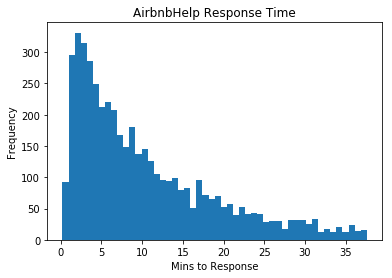

AirbnbHelp's average response time is 10.3 minutes.


In [0]:
#I saw it says 94 mins is the average time it takes for a response. This does not seem realistic.
#Focusing in on Uber and taking out outliers.

AB = messy[messy['author_id_x'] == 'AirbnbHelp']
AB_times = AB['converted_time']

AB_times.dropna()

def remove_outlier(AB_times):
    q1 = AB_times.quantile(0.25)
    q3 = AB_times.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = AB_times.loc[(AB_times > fence_low) & (AB_times < fence_high)]
    return df_out

no_outliers = remove_outlier(AB_times)

import matplotlib.pyplot as plt
hist_plot = no_outliers.plot.hist(bins=50)
hist_plot.set_title('AirbnbHelp Response Time')
hist_plot.set_xlabel('Mins to Response')
hist_plot.set_ylabel('Frequency')
plt.show()

print('AirbnbHelp\'s average response time is ' + str(round(no_outliers.mean(),2)) + ' minutes.' )

## ordering the conversations logically

In [0]:
#collecting all the unique author id's
All_author_ids = set(subset2.author_id)
All_author_ids.remove('AirbnbHelp')


In [0]:

import numpy as np
#array containing the correct order index to be used on data
correct_order = np.arange(len(subset2))
#array containig the dialog id, count a unique number indicating each dialog (i hope this is what you meant when we discussed)
dialog_index = np.zeros(len(subset2), dtype=np.int16)

#the main magic
for i, author_id in enumerate(All_author_ids):
    #boolean array: true where condition indidcated is met
    index = (subset2.author_id == author_id) | subset2.text.str.contains(str(author_id), na=True)
    #sampling the data, and ordering sample by time (created_at)
    order = subset2.created_at[index].argsort()
    #rearranging the chuncks of the correct_order array based in order above
    correct_order[index] = correct_order[index][order]
    dialog_index[index] = i
    
subset2 = subset2.reindex(correct_order)
subset2.insert(5, 'dialog_index', dialog_index)
# subset2.to_csv('AppleSupport1-ordered.csv')

In [0]:
subset2.head()

,tweet_id,author_id,inbound,created_at,text,dialog_index,response_tweet_id,in_response_to_tweet_id
9401,NaN,NaN,NaN,NaN,NaN,736,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,736,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,736,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [0]:
sub2_conv = df[(df['author_id'].str.contains('AirbnbHelp'))|df['text'].str.contains('AirbnbHelp')]

In [0]:
dia2=subset2.dialog_index.tolist()
len(dia2)

15387

In [0]:
sub2_conv['dialog_index']=dia2
sub2_conv.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,dialog_index
213,303,AirbnbHelp,False,Tue Oct 31 22:09:51 +0000 2017,@115782 Thank you for that. We have responded ...,NaN,304.0,736
214,304,115782,True,Tue Oct 31 22:04:54 +0000 2017,@AirbnbHelp I've just sent you a message with ...,303,305.0,736
215,305,AirbnbHelp,False,Tue Oct 31 21:46:05 +0000 2017,"@115782 Hi there, we would like to help. Pleas...",304,306.0,736
217,307,AirbnbHelp,False,Tue Oct 31 21:49:58 +0000 2017,@115784 We are sorry to hear this. Please DM y...,NaN,308.0,0
1617,2327,AirbnbHelp,False,Tue Oct 31 22:37:27 +0000 2017,@116238 We would like to look into this for yo...,NaN,2328.0,0


## grouping the conversations

In [0]:
list_conv2=sub2_conv.groupby('dialog_index').size().tolist()
avg_length2 =sum(list_conv2)/len(list_conv2)                       
avg_length2

4.499122807017544

In [0]:
len(list_conv2)

3420

In [0]:
from collections import Counter
Counter(list_conv2)

# British_Airways - Subset3

In [0]:
subset3 = df[(df['author_id'].str.contains('British_Airways'))|df['text'].str.contains('British_Airways')]
subset3.shape

(59883, 7)

## Analysing response time

In [0]:
#Separating the original dataframe into inbounds and outbounds
inbounds = subset3.loc[subset3['inbound'] == True]
outbounds = subset3.loc[subset3['inbound'] == False]

#Merging/joining to be able to later find time between responses. Messy as a variable because the table looks so messy.
messy = pd.merge(outbounds, inbounds, left_on='in_response_to_tweet_id', right_on='tweet_id', how='outer')

#Changing timestamp format
messy['outbound_time'] = pd.to_datetime(messy['created_at_x'], format='%a %b %d %H:%M:%S +0000 %Y')
messy['inbound_time'] = pd.to_datetime(messy['created_at_y'], format='%a %b %d %H:%M:%S +0000 %Y')

#Calculating time between between outbound response and inbound message
messy['response_time'] = messy['outbound_time'] - messy['inbound_time']

messy.head()

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y,outbound_time,inbound_time,response_time
0,867.0,British_Airways,False,Tue Oct 31 22:28:36 +0000 2017,@115892 caused. We're unable to offer a compli...,"868,869,870,871",872.0,872.0,115892,True,Tue Oct 31 16:08:21 +0000 2017,Hi @British_Airways! My flight from MAN--LHR--...,"867,874",NaN,2017-10-31 22:28:36,2017-10-31 16:08:21,06:20:15
1,874.0,British_Airways,False,Tue Oct 31 22:26:30 +0000 2017,@115892 We're so sorry to hear your flight was...,1980634,872.0,872.0,115892,True,Tue Oct 31 16:08:21 +0000 2017,Hi @British_Airways! My flight from MAN--LHR--...,"867,874",NaN,2017-10-31 22:26:30,2017-10-31 16:08:21,06:18:09
2,873.0,British_Airways,False,Wed Nov 01 09:35:44 +0000 2017,@115892 Please can you DM us your booking refe...,NaN,868.0,868.0,115892,True,Tue Oct 31 22:34:33 +0000 2017,"@British_Airways Sure, how much would an upgra...",873,867.0,2017-11-01 09:35:44,2017-10-31 22:34:33,11:01:11
3,875.0,British_Airways,False,Tue Oct 31 22:26:11 +0000 2017,@115893 email address and contact telephone nu...,876,877.0,877.0,115893,True,Tue Oct 31 16:47:55 +0000 2017,@British_Airways will you ever address my com...,"875,878,879",NaN,2017-10-31 22:26:11,2017-10-31 16:47:55,05:38:16
4,879.0,British_Airways,False,Tue Oct 31 22:25:34 +0000 2017,@115893 We apologise for not responding sooner...,NaN,877.0,877.0,115893,True,Tue Oct 31 16:47:55 +0000 2017,@British_Airways will you ever address my com...,"875,878,879",NaN,2017-10-31 22:25:34,2017-10-31 16:47:55,05:37:39


In [0]:
#Making sure the data type is a timedelta/duration
print('from ' + str(messy['response_time'].dtype))


#Making it easier to later do averages by converting to a float datatype
messy['converted_time'] = messy['response_time'].astype('timedelta64[s]') / 60

print('to ' + str(messy['converted_time'].dtype))

from timedelta64[ns]
to float64


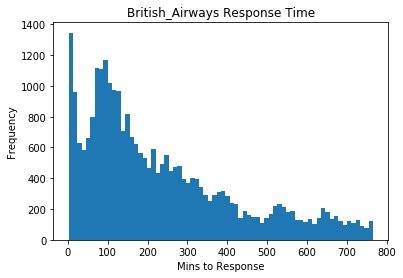

British_Airways's average response time is 231.85 minutes.


In [0]:

#Focusing in on Uber and taking out outliers.

BA = messy[messy['author_id_x'] == 'British_Airways']
BA_times = BA['converted_time']

BA_times.dropna()

def remove_outlier(BA_times):
    q1 = BA_times.quantile(0.25)
    q3 = BA_times.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = BA_times.loc[(BA_times > fence_low) & (BA_times < fence_high)]
    return df_out

no_outliers = remove_outlier(BA_times)

import matplotlib.pyplot as plt
hist_plot = no_outliers.plot.hist(bins=70)
hist_plot.set_title('British_Airways Response Time')
hist_plot.set_xlabel('Mins to Response')
hist_plot.set_ylabel('Frequency')
plt.show()

print('British_Airways\'s average response time is ' + str(round(no_outliers.mean(),2)) + ' minutes.' )

## Ordering the conversations

In [0]:
#collecting all the unique author id's
All_author_ids = set(subset3.author_id)
All_author_ids.remove('British_Airways')


In [0]:
import numpy as np
#array containing the correct order index to be used on data
correct_order = np.arange(len(subset3))
#array containig the dialog id, count a unique number indicating each dialog (i hope this is what you meant when we discussed)
dialog_index = np.zeros(len(subset3), dtype=np.int16)

#the main magic
for i, author_id in enumerate(All_author_ids):
    #boolean array: true where condition indidcated is met
    index = (subset3.author_id == author_id) | subset3.text.str.contains(str(author_id), na=True)
    #sampling the data, and ordering sample by time (created_at)
    order = subset3.created_at[index].argsort()
    #rearranging the chuncks of the correct_order array based in order above
    correct_order[index] = correct_order[index][order]
    dialog_index[index] = i
    
subset3 = subset3.reindex(correct_order)
subset3.insert(5, 'dialog_index', dialog_index)
# subset2.to_csv('AppleSupport1-ordered.csv')

In [0]:
sub3_conv = df[(df['author_id'].str.contains('British_Airways'))|df['text'].str.contains('British_Airways')]

In [0]:
dia3=subset3.dialog_index.tolist()
len(dia3)

59883

In [0]:
sub3_conv['dialog_index']=dia3
sub3_conv.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,dialog_index
558,867,British_Airways,False,Tue Oct 31 22:28:36 +0000 2017,@115892 caused. We're unable to offer a compli...,"868,869,870,871",872.0,1423
559,868,115892,True,Tue Oct 31 22:34:33 +0000 2017,"@British_Airways Sure, how much would an upgra...",873,867.0,1423
560,873,British_Airways,False,Wed Nov 01 09:35:44 +0000 2017,@115892 Please can you DM us your booking refe...,NaN,868.0,1423
561,869,115892,True,Wed Nov 01 08:44:59 +0000 2017,"@British_Airways Or, more importantly, are the...",NaN,867.0,1423
562,870,115892,True,Wed Nov 01 08:48:52 +0000 2017,@British_Airways This itinerary is preferred--...,NaN,867.0,1423


## grouping the conversations

In [0]:
list_conv3=sub3_conv.groupby('dialog_index').size().tolist()
avg_length3 =sum(list_conv3)/len(list_conv3)                       
avg_length3

4.171287266648092

In [0]:
len(list_conv3)

14356

In [0]:
from collections import Counter
Counter(list_conv3)

Counter({1: 453,
         2: 5583,
         3: 2271,
         4: 2086,
         5: 1134,
         6: 793,
         7: 508,
         8: 380,
         9: 266,
         10: 194,
         11: 148,
         12: 131,
         13: 80,
         14: 51,
         15: 55,
         16: 36,
         17: 28,
         18: 24,
         19: 18,
         20: 9,
         21: 16,
         22: 14,
         23: 9,
         24: 5,
         25: 11,
         26: 5,
         27: 5,
         28: 2,
         29: 3,
         30: 1,
         33: 4,
         34: 2,
         35: 8,
         36: 2,
         37: 1,
         39: 1,
         40: 2,
         43: 2,
         48: 1,
         53: 2,
         54: 2,
         56: 1,
         60: 2,
         70: 1,
         72: 1,
         86: 1,
         89: 1,
         97: 1,
         308: 1,
         326: 1})

### Load the combined datasets

In [0]:
print(subset1.shape,
subset2.shape,
subset3.shape)

(204028, 7) (15387, 7) (59883, 7)


In [0]:
frames=[subset1[:2000], subset2[:2000], subset[:3]]

# Pre-Processing steps



## count distribution

In [0]:
print(df.count())

## value count on the dialog_act column

In [0]:
# Select a column of the dataframe
subreddits = threads['subreddit']
print(type(subreddits))

subreddit_counts = subreddits.value_counts()

# The result is a new series with the counts of the unique values.
print(type(subreddit_counts))
print()
# describe() can be called to provide a summary of the values
print("Description of subreddit statistics:")
print(subreddit_counts.describe())
print()


# Get the top ones.
print("Top subreddits:")
print (subreddit_counts.head())


## number of tokens

In [0]:
all_posts_tokenized = post_frame.body.apply(tokenize)

import itertools
# A single variable with the (flattened) tokens from all posts.
flat_tokens = list(itertools.chain.from_iterable(all_posts_tokenized))

# all tokens
N = len(set(flat_tokens))
print(N)


## average length of turns

In [0]:
avg_len = N / len(all_posts_tokenized)
print(avg_len)


## 50 most frequent (common) tokens in the collection + term frequencies (TF).

In [0]:
word_count = collections.Counter(flat_tokens)
word_count.most_common(50)


In [0]:
from collections import Counter
cnt = Counter()
for text in df["text_wo_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

## lemmatization

Now we are getting the root form run. So we also need to provide the POS tag of the word along with the word for lemmatizer in nltk. Depending on the POS, the lemmatizer may return different results.

Let us take the example, stripes and check the lemma when it is both verb and noun.

In [0]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["text_lemmatized"] = df["text"].apply(lambda text: lemmatize_words(text))
df.head()

## Conversion of Emoticon to Words
This method might be better for some use cases when we do not want to miss out on the emoticon information

In [0]:
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

text = "Hello :-) :-)"
convert_emoticons(text)

In [0]:
text = "I am sad :()"
convert_emoticons(text)

## Conversion of Emoji to Words

In [0]:
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
    return text

text = "game is on 🔥"
convert_emojis(text)

In [0]:
text = "Hilarious 😂"
convert_emojis(text)text = "Hilarious 😂"
convert_emojis(text)

## Chat Words Conversion
This is an important text preprocessing step if we are dealing with chat data. People do use a lot of abbreviated words in chat and so it might be helpful to expand those words for our analysis purposes.

Got a good list of chat slang words from this repo. We can use this for our conversion here. We can add more words to this list.

In [0]:
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

chat_words_conversion("one minute BRB")